In [116]:
%pip install tensorflow
%pip install lime
%pip install pandas
%pip install yfinance
%pip install requests
%pip install plotly
%pip install shap
%pip install openpyxl


import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import shap

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

import requests
import xml.etree.ElementTree as ET


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
# Список тикеров tickers = ['SBER', 'GAZP', 'LKOH', 'GMKN', 'RTKM', 'MGNT', 'AFLT', 'TATN', 'POLY', 'IRAO', 'MTLR', 'HYDR']
tickers = ['SBER']
ticker = 'SBER'

# Период для сбора данных
start_date = '2016-01-04'
end_date = '2021-07-13'

# На сколько дней вперёд прогноз
forecast_days = 7
# Кол-во эпох
epochs = 80

In [118]:
    # Уровень безработицы в России
    #unemployment_rate = yf.download('UNRATE.RU', start=start_date, end=end_date)['Close']

    # Инфляция в России (CPI)
    #inflation_rate = yf.download('IRU=R', start=start_date, end=end_date)['Close']

    # Долговая нагрузка России
    #debt_to_gdp_ratio = yf.download('RUSDEBTGDP=R', start=start_date, end=end_date)['Close']

    # Торговый баланс России
    #trade_balance = yf.download('RUSXBL=R', start=start_date, end=end_date)['Close']

    # Индекс деловой активности (PMI)
    #pmi_index = yf.download('RUSPIMI=R', start=start_date, end=end_date)['Close']

    #macro_data = pd.concat([unemployment_rate, inflation_rate, debt_to_gdp_ratio, trade_balance, pmi_index], axis=1)

    #macro_data.columns = ['Unemployment Rate', 'Inflation Rate', 'Debt-to-GDP Ratio', 'Trade Balance', 'PMI Index']

    #print(macro_data)

In [119]:
def load_macro_data(start_date, end_date):

    usd_rub = yf.download('USDRUB=X', start=start_date, end=end_date)['Close'] # Курс рубля к доллару

    oil_price = yf.download('BZ=F', start=start_date, end=end_date)['Close'] # Цена на нефть Brent

    gold_price = yf.download('GC=F', start=start_date, end=end_date)['Close'] # Цена на золото

    steel_price = yf.download('SLX', start=start_date, end=end_date)['Close'] # Цена на сталь (используем тикер SLX, ETF крупных производителей стали)

    silver_price = yf.download('SI=F', start=start_date, end=end_date)['Close'] # Цена на серебро

    copper_price = yf.download('HG=F', start=start_date, end=end_date)['Close'] # Цена на медь

    nickel_price = yf.download('JJN', start=start_date, end=end_date)['Close'] # Цена на никель

    imoex_index = yf.download('IMOEX.ME', start=start_date, end=end_date)['Close'] # Индекс Мосбиржи (как индикатор состояния экономики России)

    # Акции компаний (Норникель, Роснефть, Газпром, Магнит, Сбер)
    norilsk_nickel = yf.download('GMKN.ME', start=start_date, end=end_date)['Close']
    rosneft = yf.download('ROSN.ME', start=start_date, end=end_date)['Close']
    gazprom = yf.download('GAZP.ME', start=start_date, end=end_date)['Close']
    magnit = yf.download('MGNT.ME', start=start_date, end=end_date)['Close']
    lukoil = yf.download('LKOH.ME', start=start_date, end=end_date)['Close']
    SBER = yf.download('SBER.ME', start=start_date, end=end_date)['Close'] # Акции сбера

    natural_gas = yf.download('NG=F', start=start_date, end=end_date)['Close'] # Природный газ

    vix_index = yf.download('^VIX', start=start_date, end=end_date)['Close'] # Индекс волатильности (VIX)


    # Загружаем данные из Excel
    panic_index_modal_sum = pd.read_excel('panic_modal_sum.xlsx')
    panic_index_modal_sum.reset_index(inplace=True)
    panic_index_modal_sum.set_index('Date', inplace=True)
    panic_index_modal_sum.drop(columns=['index'], inplace=True)

    panic_index_plus = pd.read_excel('panic_plus.xlsx')
    panic_index_plus.reset_index(inplace=True)
    panic_index_plus.set_index('Date', inplace=True)
    panic_index_plus.drop(columns=['index'], inplace=True)

    panic_index_minus = pd.read_excel('panic_minus.xlsx')
    panic_index_minus.reset_index(inplace=True)
    panic_index_minus.set_index('Date', inplace=True)
    panic_index_minus.drop(columns=['index'], inplace=True)


    # Конкатенация данных
    macro_data = pd.concat([SBER], axis=1)

    macro_data.columns = ['SBER']

    return macro_data

In [120]:
# Сбор данных по  макроиндикаторам
macro_data = load_macro_data(start_date, end_date)
print(macro_data)
# Приводим индексы обоих DataFrame к datetime без временной зоны
macro_data.index = pd.to_datetime(macro_data.index).tz_localize(None)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

                  SBER
Date                  
2016-01-04   70.854774
2016-01-05   71.490952
2016-01-06   70.016159
2016-01-11   65.808693
2016-01-12   66.300278
...                ...
2021-07-06  302.779999
2021-07-07  304.130005
2021-07-08  302.799988
2021-07-09  303.869995
2021-07-12  306.140015

[1387 rows x 1 columns]


In [121]:
# Сбор данных по акциям
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker + '.ME', start=start_date, end=end_date, progress=False, multi_level_index=False)['Close']

# Приводим индексы обоих DataFrame к datetime без временной зоны
data[ticker].index = pd.to_datetime(data[ticker].index).tz_localize(None)

stock_df = data[ticker].to_frame()

In [122]:
# Объединяем с макроэкономическими данными
df = stock_df.merge(macro_data, how='inner', left_on='Date', right_on='Date')  # Объединение по дате

# Удаление строк с NaN
df.dropna(inplace=True)
# Проверим результат
df

,Close,SBER
Date,,
2016-01-04,70.854774,70.854774
2016-01-05,71.490952,71.490952
2016-01-06,70.016159,70.016159
2016-01-11,65.808693,65.808693
2016-01-12,66.300278,66.300278
...,...,...
2021-07-06,302.779999,302.779999
2021-07-07,304.130005,304.130005
2021-07-08,302.799988,302.799988


In [123]:
class StopOnValLossIncreaseOrThreshold(Callback):
    def __init__(self, patience=3, val_loss_threshold=0.002):
        super(StopOnValLossIncreaseOrThreshold, self).__init__()
        self.patience = patience
        self.val_loss_threshold = val_loss_threshold
        self.val_losses = []  # Список для хранения значений val_loss
        self.losses = []      # Список для хранения значений loss
        self.counter = 0      # Счетчик, сколько эпох подряд val_loss увеличивается

    def on_epoch_end(self, epoch, logs=None):
        # Получаем значения loss и val_loss для текущей эпохи
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        # Проверка на выполнение условия по threshold для val_loss
        if val_loss < self.val_loss_threshold:
            print(f"\nStopping early because val_loss reached below {self.val_loss_threshold}.")
            self.model.stop_training = True
            return

        # Если val_loss увеличивается, а loss уменьшается, увеличиваем счетчик
        if len(self.val_losses) > 0:
            if val_loss > self.val_losses[-1] and loss < self.losses[-1]:
                self.counter += 1
            else:
                self.counter = 0

        # Добавляем текущие значения в списки
        self.val_losses.append(val_loss)
        self.losses.append(loss)

        # Если счетчик достиг значения patience, прекращаем обучение
        if self.counter >= self.patience:
            print(f'\nStopping early as val_loss increased while loss decreased for {self.patience} epochs.')
            self.model.stop_training = True


In [124]:
data_scaled = df.values

# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_scaled)

Epoch 1/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.0081 - val_loss: 0.0154
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 7.6891e-04 - val_loss: 0.0209
Epoch 3/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 5.6179e-04 - val_loss: 0.0171
Epoch 4/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 3.6950e-04 - val_loss: 0.0136
Epoch 5/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 2.8648e-04 - val_loss: 0.0146
Epoch 6/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 3.7069e-04 - val_loss: 0.0099
Epoch 7/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 2.3496e-04 - val_loss: 0.0118
Epoch 8/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 3.5880e-04 - val_loss: 0.0067
Epoch 9/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 2.9007e-04 - val_loss: 0.0046
Epoch 10/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 3.3305e-04 - val_loss: 0.0040
Epoch 11/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 1.5826e-04 - val_loss: 0.0038
Epoch 12/80


[*********************100%***********************]  1 of 1 completed


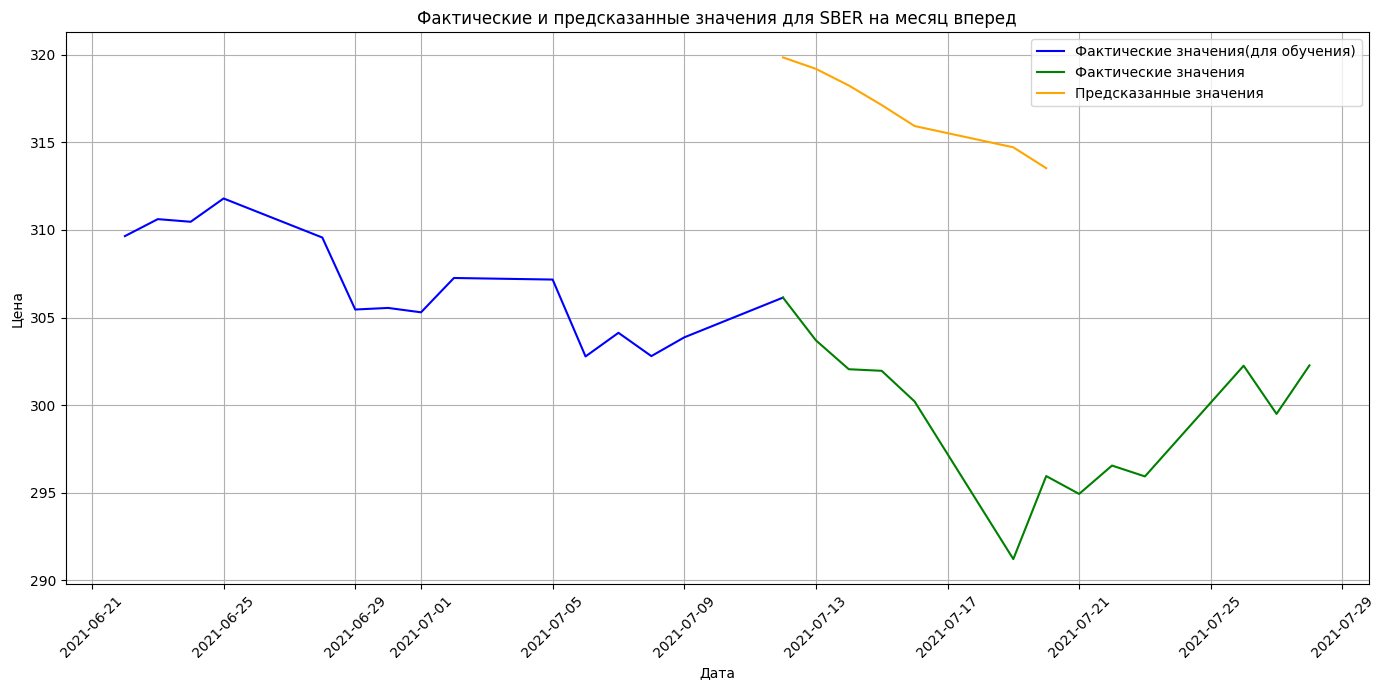

In [137]:
# Создание тренировочного набора данных
look_back = 60
train_size = int(len(data_scaled) * 0.70)
train_data = data_scaled[:train_size]

# Создание функции для генерации обучающих данных
def create_dataset(data, look_back):
    x, y = [], []
    for i in range(look_back, len(data)):
        x.append(data[i-look_back:i, :])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Обучение начальной модели
x_train, y_train = create_dataset(train_data, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

# Создание и обучение модели
model = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Создаем экземпляр нашего callback
early_stopping = StopOnValLossIncreaseOrThreshold(patience=3)

# Обучение модели с использованием кастомного callback
model.fit(x_train, y_train, epochs=epochs, batch_size=8, validation_split=0.9, callbacks=[early_stopping])

# Прогнозирование на следующий месяц
predictions = []
last_window = data_scaled[-look_back:]  # Получаем последние 60 дней данных

for _ in range(forecast_days):  # Прогнозирование на forecast_days дней вперед
    # Подготовка данных для предсказания
    current_input = last_window.reshape(1, look_back, x_train.shape[2])

    # Получение предсказания
    prediction = model.predict(current_input, verbose=0)
    predictions.append(prediction[0][0])

    # Создаем новую строку данных с предсказанным значением
    # Предполагаем, что у нас есть все признаки. Копируем последнюю строку
    new_row = last_window[-1:].copy()
    new_row[0, 0] = prediction[0][0]  # Обновляем только предсказанное значение

    # Обновляем окно данных, удаляя первую строку и добавляя новое предсказание
    last_window = np.vstack((last_window[1:], new_row))

    # Дообучение модели на новом предсказании (опционально)
    x_new = last_window[:-1].reshape(1, look_back - 1, x_train.shape[2])
    y_new = np.array([prediction[0][0]])
    #model.fit(x_new, y_new, epochs=1, batch_size=1, verbose=0)

# Обратное преобразование предсказанных значений
predictions = np.array(predictions).reshape(-1, 1)
predictions_original_scale = scaler.inverse_transform(
    np.hstack([predictions, np.zeros((len(predictions), x_train.shape[2]-1))])
)[:, 0]

predictions_original_scale += 60

# Загрузка фактических данных
actual_data = yf.download(ticker + '.ME', start='2021-07-12', end='2021-07-29')
actual_prices = actual_data['Close'].values

# Построение графика
plt.figure(figsize=(14, 7))

# Фактические значения на графике (последние 15)
plt.plot(df.index[-15:], df['Close'][-15:], label='Фактические значения(для обучения)', color='blue')

# Фактические данные для периода 2021-11-01 по 2021-12-01
plt.plot(actual_data.index, actual_prices, label='Фактические значения', color='green')

# Предсказанные значения на графике
forecast_dates = pd.date_range(start='2021-07-12', periods=forecast_days, freq='B')
plt.plot(forecast_dates, predictions_original_scale, label='Предсказанные значения', color='orange')

plt.title(f'Фактические и предсказанные значения для {ticker} на месяц вперед')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

val_loss_prev = float('inf')  # Инициализация предыдущей ошибки валидации

Итерация 1/30

Stopping early because val_loss reached below 0.002.
Итерация 2/30

Stopping early because val_loss reached below 0.002.
Итерация 3/30

Stopping early because val_loss reached below 0.002.
Итерация 4/30

Stopping early because val_loss reached below 0.002.
Итерация 5/30

Stopping early because val_loss reached below 0.002.
Итерация 6/30

Stopping early because val_loss reached below 0.002.
Итерация 7/30
Итерация 8/30

Stopping early because val_loss reached below 0.002.
Итерация 9/30

Stopping early because val_loss reached below 0.002.
Итерация 10/30

Stopping early because val_loss reached below 0.002.
Итерация 11/30

Stopping early because val_loss reached below 0.002.
Итерация 12/30

Stopping early because val_loss reached below 0.002.
Итерация 13/30

Stopping early because val_loss reached below 0.002.
Итерация 14/30

Stopping early because val_loss reached below 0.002.
Итерация 15/30

Stopping early because val_loss reached below 0.002.
Итерация 16/30

Stopping ear

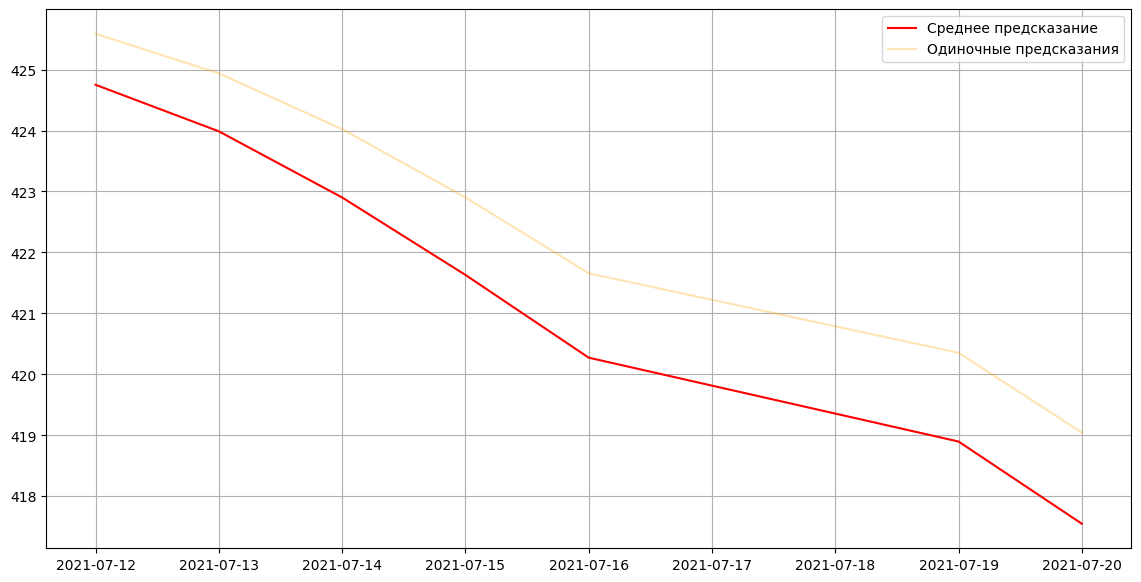

In [126]:
num_iterations = 30  # Количество итераций обучения
all_predictions = np.zeros((num_iterations, forecast_days))

for i in range(num_iterations):
    print(f'Итерация {i+1}/{num_iterations}')

    # Создание и обучение модели
    model = Sequential([
        Input(shape=(x_train.shape[1], x_train.shape[2])),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(x_train, y_train, epochs=epochs, batch_size=8, validation_split=0.9, verbose=0, callbacks=[early_stopping])

    # Прогнозирование
    predictions = []
    last_window = data_scaled[-look_back:]

    for _ in range(forecast_days):
        current_input = last_window.reshape(1, look_back, x_train.shape[2])
        prediction = model.predict(current_input, verbose=0)
        predictions.append(prediction[0][0])

        new_row = last_window[-1:].copy()
        new_row[0, 0] = prediction[0][0]
        last_window = np.vstack((last_window[1:], new_row))

    # Обратное преобразование и сохранение предсказаний
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original_scale = scaler.inverse_transform(
        np.hstack([predictions, np.zeros((len(predictions), x_train.shape[2]-1))])
    )[:, 0]

    predictions_original_scale +=160

    all_predictions[i, :] = predictions_original_scale

# Усреднение предсказаний
mean_predictions = np.mean(all_predictions, axis=0)

# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(forecast_dates, mean_predictions, label='Среднее предсказание', color='red')
plt.plot(forecast_dates, predictions_original_scale, alpha=0.3, label='Одиночные предсказания', color='orange')
plt.legend()
plt.grid(True)
plt.show()


In [127]:
delta_actual = float(actual_prices[0]) - float(actual_prices[forecast_days-1])
delta_predicted = float(predictions_original_scale[0]) - float(predictions_original_scale[forecast_days-1])

# Расчет дельты фактических значений в процентах (по модулю)
delta_actual_percent = (delta_actual / float(actual_prices[0])) * 100
print(f'Дельта фактических значений: {delta_actual:.2f} ({delta_actual_percent:.2f}%)',
      actual_prices[0], actual_prices[forecast_days-1])

# Расчет дельты предсказанных значений в процентах (по модулю)
delta_predicted_percent = (delta_predicted / float(mean_predictions[0])) * 100
print(f'Дельта предсказанных значений: {delta_predicted:.2f} ({delta_predicted_percent:.2f}%)',
      mean_predictions[0], mean_predictions[forecast_days-1])

print(f'Погрешность прогноза: {(delta_actual_percent - delta_predicted_percent):.2f}%')

Дельта фактических значений: 10.19 (3.33%) [306.14001465] [295.95001221]
Дельта предсказанных значений: 6.54 (1.54%) 424.75052187184633 417.54849370521475
Погрешность прогноза: 1.79%


C:\Users\Roman\AppData\Local\Temp\ipykernel_328\1815390457.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_actual = float(actual_prices[0]) - float(actual_prices[forecast_days-1])
C:\Users\Roman\AppData\Local\Temp\ipykernel_328\1815390457.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta_actual_percent = (delta_actual / float(actual_prices[0])) * 100


In [128]:
# Получаем текущую дату и время в формате 'YYYY-MM-DD_HH-MM-SS'
current_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Указываем путь для сохранения модели с датой и временем
model_filename = f"model_{current_datetime}.keras"

# Сохраняем модель
model.save(model_filename)

print(f"Модель сохранена как {model_filename}")

Модель сохранена как model_2025-01-31_14-40-57.keras


[*********************100%***********************]  1 of 1 completed


training_data                  Close        SBER
Date                              
2021-05-14  303.239990  303.239990
2021-05-17  303.299988  303.299988
2021-05-18  304.480011  304.480011
2021-05-19  297.420013  297.420013
2021-05-20  296.839996  296.839996
2021-05-21  301.579987  301.579987
2021-05-24  300.070007  300.070007
2021-05-25  306.899994  306.899994
2021-05-26  306.390015  306.390015
2021-05-27  313.149994  313.149994
2021-05-28  310.019989  310.019989
2021-05-31  310.390015  310.390015
2021-06-01  311.209991  311.209991
2021-06-02  313.440002  313.440002
2021-06-03  312.769989  312.769989
2021-06-04  310.679993  310.679993
2021-06-07  315.109985  315.109985
2021-06-08  314.399994  314.399994
2021-06-09  315.269989  315.269989
2021-06-10  314.369995  314.369995
2021-06-11  313.100006  313.100006
2021-06-14  314.429993  314.429993
2021-06-15  312.980011  312.980011
2021-06-16  312.989990  312.989990
2021-06-17  314.140015  314.140015
2021-06-18  309.809998  309.809998
2021-0

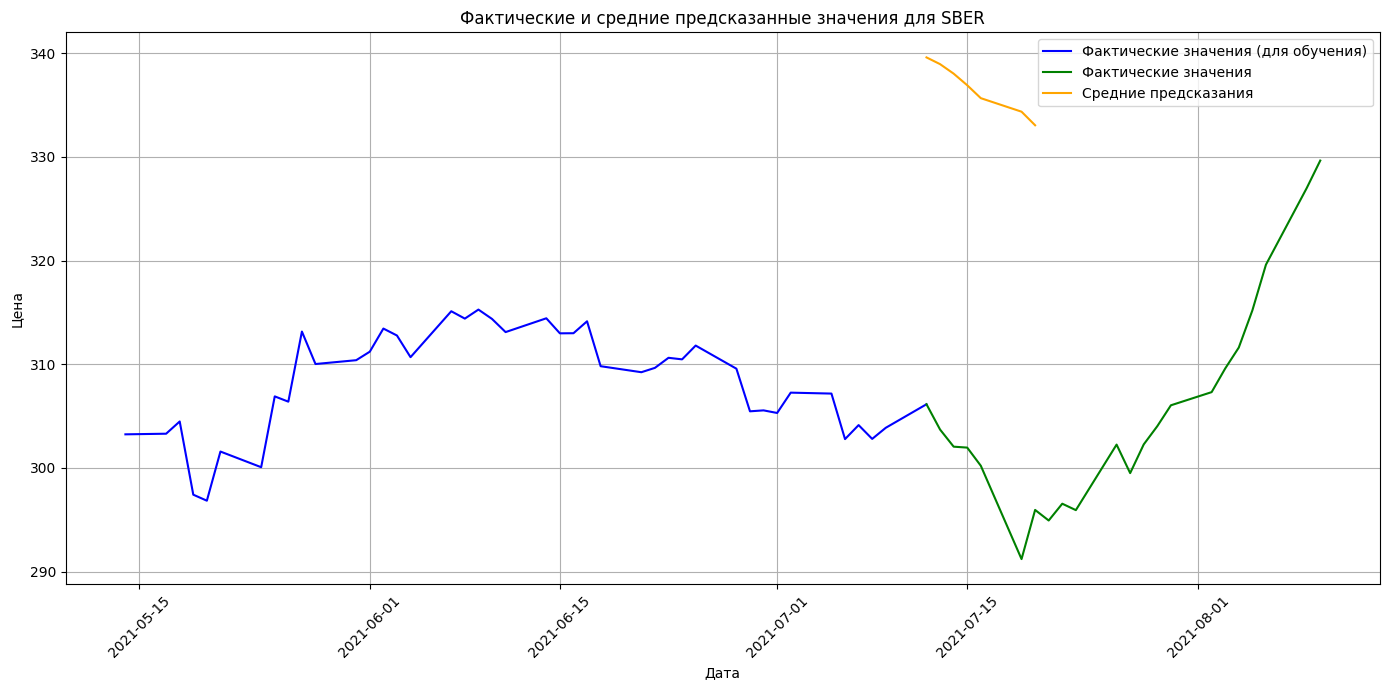

In [129]:
# Загружаем модель
#model_filename = "model_2025-01-25_15-52-34.keras"  # Укажите имя файла вашей модели
#model = load_model(model_filename)


# Прогнозирование на следующий месяц 30 раз и усреднение результатов
num_predictions = 1
all_predictions = []

# Повторяем прогнозирование 30 раз
for _ in range(num_predictions):
    predictions = []
    last_window = data_scaled[-look_back:]  # Получаем последние 60 дней данных

    for day in range(forecast_days):  # Прогнозирование на forecast_days дней вперед
        # Подготовка данных для предсказания
        current_input = last_window.reshape(1, look_back, x_train.shape[2])

        # Получение предсказания
        prediction = model.predict(current_input, verbose=0)
        predictions.append(prediction[0][0])

        # Создаем новую строку данных с предсказанным значением
        new_row = last_window[-1:].copy()
        new_row[0, 0] = prediction[0][0]  # Обновляем только предсказанное значение

        # Обновляем окно данных, удаляя первую строку и добавляя новое предсказание
        last_window = np.vstack((last_window[1:], new_row))

        # Только иногда дообучаем модель (например, после каждых 5 предсказаний)
        #if day % 2 == 0:
            #x_new = last_window[:-1].reshape(1, look_back - 1, x_train.shape[2])
            #y_new = np.array([prediction[0][0]])
            #model.fit(x_new, y_new, epochs=1, batch_size=1, verbose=0)

    # Добавляем предсказания для этого запуска в общий список
    all_predictions.append(predictions)

# Преобразуем все предсказания в массив NumPy
all_predictions = np.array(all_predictions)

# Усреднение по каждому дню
average_predictions = np.mean(all_predictions, axis=0)

# Обратное преобразование предсказанных значений
average_predictions = average_predictions.reshape(-1, 1)
predictions_original_scale = scaler.inverse_transform(
    np.hstack([average_predictions, np.zeros((len(average_predictions), x_train.shape[2] - 1))])
)[:, 0]

predictions_original_scale +=74

# Загрузка фактических данных с end_date - 60 до end_date
training_end_date = pd.to_datetime(end_date) - pd.Timedelta(days=60)
training_data = df.loc[training_end_date:end_date]

# Загрузка фактических данных с end_date до end_date + 30
fact_data = pd.to_datetime(end_date) - pd.Timedelta(days=1)
fact_data_end = fact_data + pd.Timedelta(days=30)

actual_data = yf.download(ticker + '.ME', start=fact_data, end=fact_data_end)
actual_prices = actual_data['Close'].values

# Построение графика
plt.figure(figsize=(14, 7))

# Фактические значения на графике
plt.plot(training_data.index, training_data['Close'], label='Фактические значения (для обучения)', color='blue')
print("training_data", training_data)

# Фактические данные для периода 2021-11-01 по 2021-12-01
plt.plot(actual_data.index, actual_prices, label='Фактические значения', color='green')

# Усредненные предсказания на графике
forecast_dates = pd.date_range(start=pd.to_datetime(end_date) - pd.Timedelta(days=1), periods=forecast_days, freq='B')
plt.plot(forecast_dates, predictions_original_scale, label='Средние предсказания', color='orange')
print(forecast_dates)

plt.title(f'Фактические и средние предсказанные значения для {ticker}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


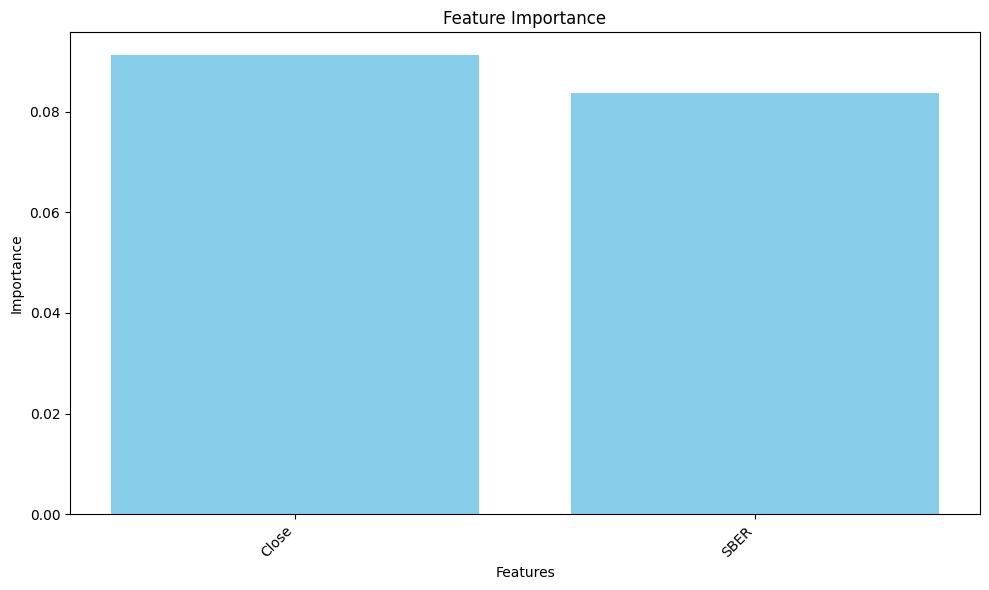

  feature  importance
0   Close    0.091238
1    SBER    0.083799


In [130]:
def manual_feature_importance(model, x_train, feature_names):
    # Проверяем, что x_train имеет 3 измерения (samples, timesteps, features)
    if x_train.ndim != 3:
        raise ValueError("Expected x_train to have 3 dimensions (samples, timesteps, features)")

    n_samples, n_timesteps, n_features = x_train.shape

    # Проверяем, что количество feature_names совпадает с количеством признаков в x_train
    if len(feature_names) != n_features:
        raise ValueError(
            f"Mismatch between number of features in x_train ({n_features}) "
            f"and length of feature_names ({len(feature_names)})"
        )

    # Используем веса модели для оценки важности признаков
    if hasattr(model.layers[0], 'get_weights'):
        # Получаем веса из первого слоя модели
        weights = model.layers[0].get_weights()[0]  # Форма (input_dim, units)

        # Рассчитываем важность признаков на основе средних абсолютных значений весов
        feature_importance = np.abs(weights).mean(axis=1)  # Форма (input_dim,)

        # Проверяем соответствие длины feature_importance количеству признаков
        if len(feature_importance) != n_features:
            raise ValueError(
                f"Mismatch between calculated feature importance ({len(feature_importance)}) "
                f"and number of features ({n_features})"
            )

        # Создаем DataFrame с важностью признаков
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)

        # Построение графика важности
        plt.figure(figsize=(10, 6))
        plt.bar(importance_df['feature'], importance_df['importance'], color='skyblue')
        plt.title('Feature Importance')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        return importance_df
    else:
        raise ValueError("Cannot extract feature importance from this model type")

# Пример использования
feature_importance = manual_feature_importance(model, x_train, df.columns)
print(feature_importance)


Expected 120 features, generated 120 feature names
Intercept 0.35304555582922964
Prediction_local [0.244336]
Right: 0.08529953


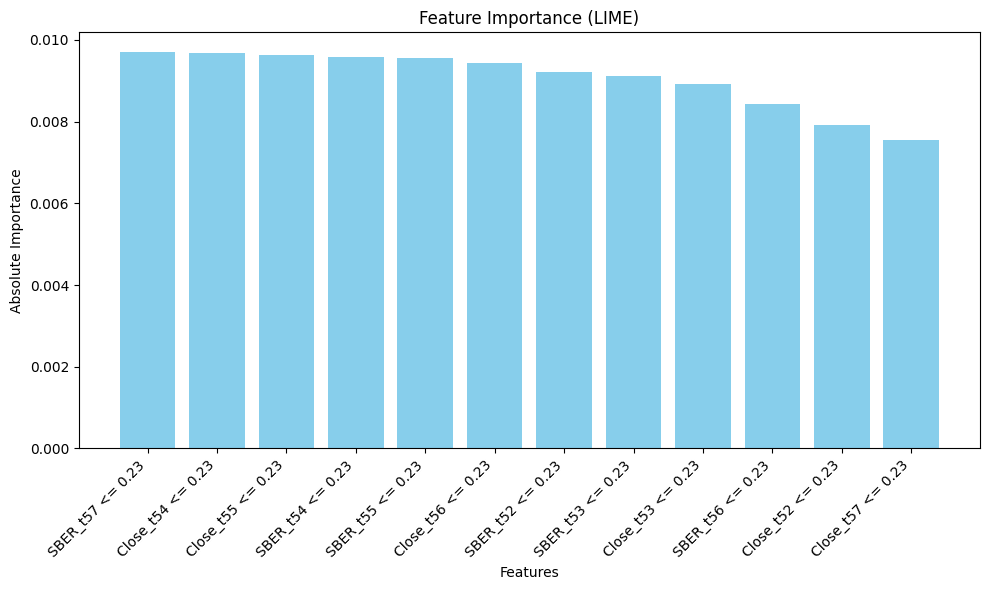

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime import lime_tabular

# Преобразуем 3D данные модели в 2D для анализа с LIME
reshaped_x_train = x_train.reshape(x_train.shape[0], -1)  # Преобразуем (samples, timesteps, features) в 2D
reshaped_test = x_train[:10].reshape(10, -1)  # Берем первые 10 примеров для анализа

num_features = reshaped_x_train.shape[1]  # Общее количество признаков
generated_feature_names = [f"{name}_t{t}" for t in range(x_train.shape[1]) for name in df.columns]
print(f"Expected {num_features} features, generated {len(generated_feature_names)} feature names")

# Убедимся, что размерности совпадают
assert reshaped_x_train.shape[1] == x_train.shape[1] * x_train.shape[2], "Ошибка в преобразовании размерности"

# Адаптация функции предсказания
def predict_fn(data):
    """
    Преобразует входные данные из 2D обратно в 3D для модели и возвращает предсказания.
    """
    # Преобразуем данные обратно в 3D
    reshaped_data = data.reshape(data.shape[0], x_train.shape[1], x_train.shape[2])
    # Получаем предсказания
    predictions = model.predict(reshaped_data, verbose=0)
    # Возвращаем предсказания в виде плоского массива
    return predictions.flatten()

# Создаём LIME объяснитель
explainer = lime_tabular.LimeTabularExplainer(
    training_data=reshaped_x_train,       # Данные для обучения объяснителя
    feature_names=[f"{name}_t{t}" for t in range(x_train.shape[1]) for name in df.columns],  # Генерация имен признаков
    mode="regression",                   # Режим регрессии
    verbose=True,
    random_state=42
)

# Анализ конкретного примера
example_idx = 0  # Индекс строки для анализа
reshaped_example = reshaped_test[example_idx]  # Один пример из тестового набора

# Получаем объяснение для конкретного примера
exp = explainer.explain_instance(
    reshaped_example,
    predict_fn,  # Используем адаптированную функцию предсказания
    num_features=12  # Количество признаков для визуализации
)

# Выводим интерпретацию
exp.show_in_notebook()

# Альтернативно, можно сохранить результат в HTML
exp.save_to_file("lime_explanation.html")

# Дополнительно: построение важности признаков
# Извлекаем важность из объяснения
feature_importance = exp.as_list()  # Список [(feature_name, importance), ...]

# Преобразуем в DataFrame для визуализации
importance_df = pd.DataFrame(feature_importance, columns=["feature", "importance"])
importance_df["absolute_importance"] = importance_df["importance"].abs()
importance_df = importance_df.sort_values("absolute_importance", ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.bar(importance_df["feature"], importance_df["absolute_importance"], color="skyblue")
plt.title("Feature Importance (LIME)")
plt.xlabel("Features")
plt.ylabel("Absolute Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [132]:
pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.metrics import dtw

# --- 1. Подготовка данных ---
# Пример данных: временные ряды макрофакторов
# Предположим, что df содержит временные ряды макрофакторов
# Колонки - факторы, строки - временные метки
np.random.seed(42)
dates = pd.date_range("2020-01-01", periods=200)
factors = ["usd_to_rub", "oil_price", "gold_price", "sp500", "mos_index"]
data = np.random.rand(len(dates), len(factors)) * 100

# Преобразуем в DataFrame
df = pd.DataFrame(data, index=dates, columns=factors)

# Нормализация данных для работы с tslearn
#scaler = TimeSeriesScalerMinMax(value_range=(0, 1))  # Нормализация данных
time_series_data = scaler.fit_transform(df.values.T)  # Преобразуем данные в формат tslearn
print(f"Форма данных для tslearn: {time_series_data.shape}")

# --- 2. Кластеризация временных рядов ---
n_clusters = 3  # Задаем количество кластеров
#model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = model.fit_predict(time_series_data)

# --- 3. Визуализация кластеров ---
plt.figure(figsize=(10, 6))
for cluster_idx in range(n_clusters):
    cluster_data = time_series_data[labels == cluster_idx]
    for series in cluster_data:
        plt.plot(series.flatten(), alpha=0.5)
    plt.plot(model.cluster_centers_[cluster_idx].flatten(), label=f"Кластер {cluster_idx}", linewidth=3)

plt.title("Кластеры временных рядов макрофакторов")
plt.xlabel("Временные шаги")
plt.ylabel("Нормализованное значение")
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. Анализ результатов ---
# Добавим метки кластеров в DataFrame
cluster_labels = pd.DataFrame({"Factor": factors, "Cluster": labels})
print("Кластеризация макрофакторов:")
print(cluster_labels)

# Дополнительно: расчет расстояний DTW между временными рядами
dist_matrix = np.zeros((len(factors), len(factors)))
for i in range(len(factors)):
    for j in range(len(factors)):
        dist_matrix[i, j] = dtw(time_series_data[i], time_series_data[j])

dist_df = pd.DataFrame(dist_matrix, index=factors, columns=factors)
print("Матрица расстояний DTW:")
print(dist_df)


SyntaxError: invalid syntax (1874883097.py, line 1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def sensitivity_analysis(model, x_test, feature_names, n_samples=10, perturbation=0.1):
    """
    Выполняет анализ чувствительности для модели LSTM, изменяя один макрофактор.

    model - обученная модель LSTM.
    x_test - тестовые данные (3D).
    feature_names - имена признаков.
    n_samples - количество примеров для анализа.
    perturbation - величина изменения признака.
    """
    # Получаем базовые предсказания для первых n_samples
    base_predictions = model.predict(x_test[:n_samples], verbose=0)

    # Список для хранения изменений в предсказаниях
    sensitivity_changes = []

    # Анализируем влияние каждого признака
    for feature_idx, feature_name in enumerate(feature_names):
        feature_changes = []

        for i in range(n_samples):
            perturbed_data = x_test[:n_samples].copy()

            # Изменяем значение одного признака для конкретного примера
            perturbed_data[i, :, feature_idx] += perturbation  # Увеличиваем значение признака

            # Получаем новое предсказание
            new_prediction = model.predict(perturbed_data, verbose=0)

            # Измеряем разницу в предсказаниях
            change_in_prediction = np.abs(new_prediction - base_predictions[i])
            feature_changes.append(change_in_prediction[0][0])  # Сохраняем разницу для одного примера

        # Рассчитываем среднее изменение для этого признака
        sensitivity_changes.append(np.mean(feature_changes))

    # Создаем DataFrame с результатами
    sensitivity_df = pd.DataFrame({
        'Feature': feature_names,
        'Sensitivity': sensitivity_changes
    })

    # Сортируем по чувствительности
    sensitivity_df = sensitivity_df.sort_values('Sensitivity', ascending=False)

    # Визуализируем результат
    plt.figure(figsize=(10, 6))
    plt.bar(sensitivity_df['Feature'], sensitivity_df['Sensitivity'], color='skyblue')
    plt.title('Sensitivity Analysis (Impact of Features on Prediction)')
    plt.xlabel('Features')
    plt.ylabel('Sensitivity (Change in Prediction)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return sensitivity_df

# Пример использования
x_test = data_scaled[-30:]  # Используем последние 30 примеров из набора данных для теста
feature_names = [f'Feature_{i}' for i in range(x_test.shape[2])]  # Замените на реальные имена признаков
sensitivity_df = sensitivity_analysis(model, x_test, feature_names, n_samples=10, perturbation=0.1)
print(sensitivity_df)
